### Préparation des données

#### Partie 2 - Traitement des images


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
from skimage import exposure

from IPython.display import display

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.filters as filter

datasets_dir = init.init('Preprocessing Partie 2')

<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - Preprocessing Partie 2**

Version              : 2
Notebook id          : Preprocessing Partie 2
Run time             : Monday 13 February 2023, 13:05:16
Hostname             : ludovic-ubu (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : /media/ludovic/Cache/ENID
Run dir              : ./run
Update keras cache   : False
numpy                : 1.21.5
skimage              : 0.19.2
matplotlib           : 3.5.1
pandas               : 1.3.5


L'objectif dans ce Notebook est de définir des traitements qui produisent le meilleur résultat pour obtenir une meilleure qualité d'image. Ainsi, dans les parties suivantes, nous allons aborder et comparer divers techniques que nous appliquerons si necessaire pour constituer le dataset.

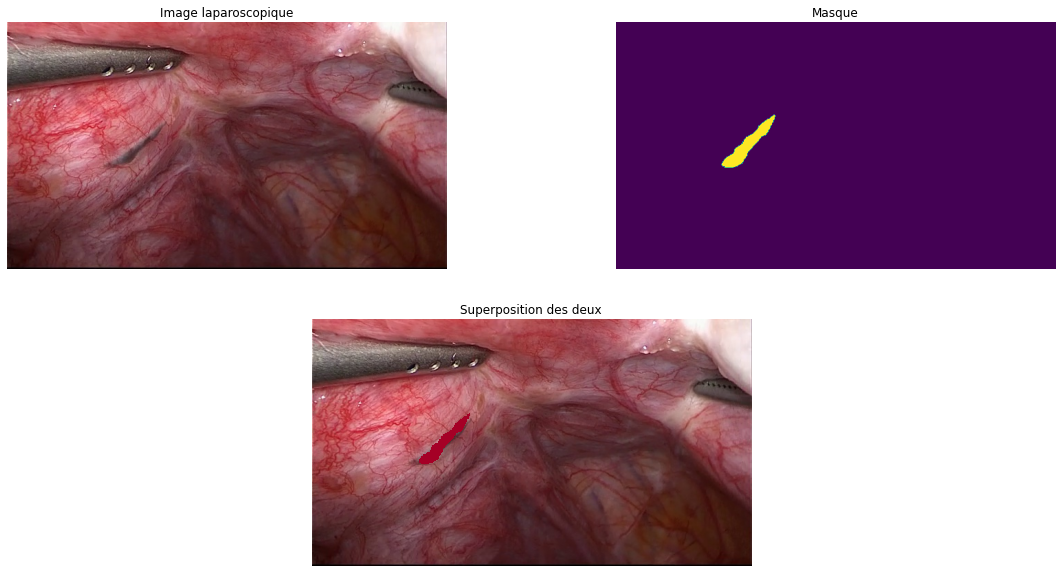

In [2]:
df = pd.read_csv('run/dataset_final.csv', header=0)

image_array, mask_array = utils.getImgMsk(df, 11203)
disp.plot3(image_array, mask_array)


In [3]:
print("Image laparoscopique 8 bits (0 à 255) : ", image_array.dtype)
print("Masque de l'image 8 bits (0 à 255) : ", mask_array.dtype)


Image laparoscopique 8 bits (0 à 255) :  uint8
Masque de l'image 8 bits (0 à 255) :  uint8


/home/ludovic/anaconda3/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
/home/ludovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/home/ludovic/anaconda3/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwar

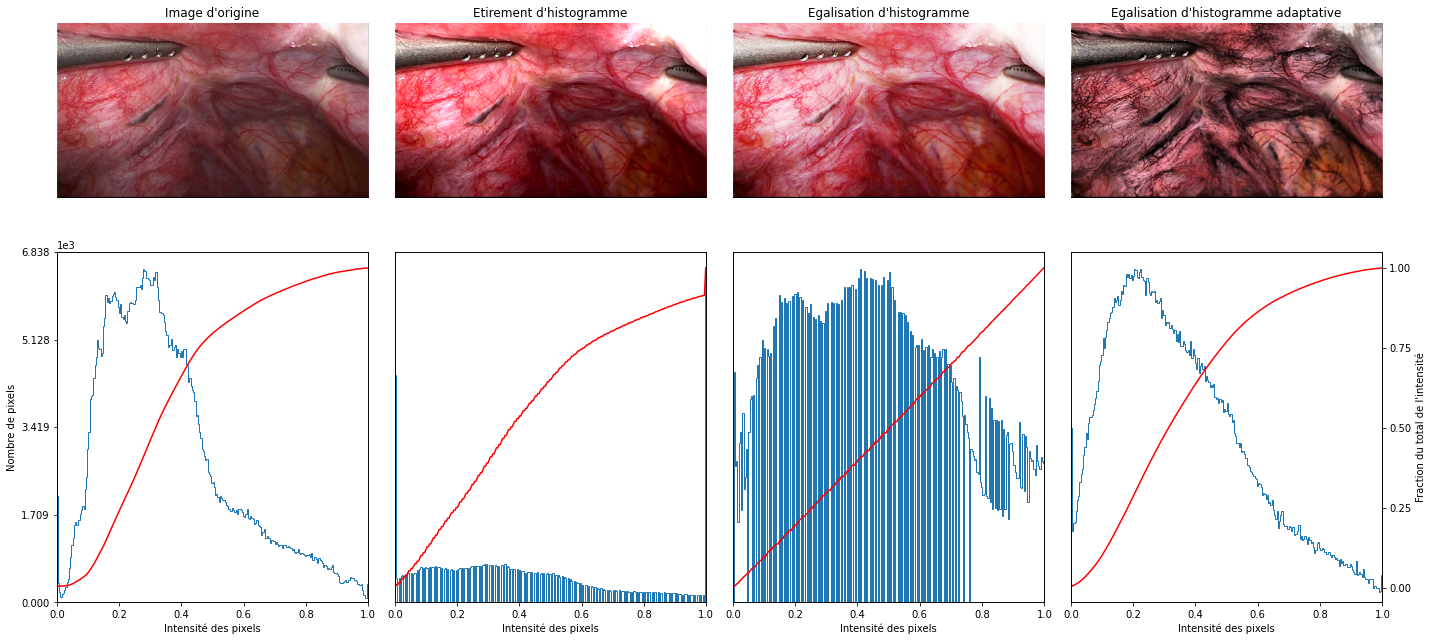

In [4]:
img = image_array

# Contrast stretching
p3, p95 = np.percentile(img, (5, 92))
img_rescale = exposure.rescale_intensity(img, in_range=(p3, p95))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(20, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = disp.plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Image d\'origine')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Nombre de pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = disp.plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Etirement d\'histogramme')

ax_img, ax_hist, ax_cdf = disp.plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Egalisation d\'histogramme')

ax_img, ax_hist, ax_cdf = disp.plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Egalisation d\'histogramme adaptative')

ax_cdf.set_ylabel('Fraction du total de l\'intensité')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

fig.tight_layout()
plt.show()

Par rapport aux résultats ci-dessus, nous pouvons par la suite choisir entre l'étirement ou l'égalisation d'histogramme. En effet, on constate qu'ils nous permettent d'obtenir une image avec un meilleur contraste. Par la suite, nous prendrons l'étirement d'histogramme car nous nous sommes aperçu que cette technique produisait de meilleurs résultats sur beaucoup d'autres images. <br>
A présent, nous pouvons appliquer des filtres pour tenter d'améliorer encore plus l'image.

In [5]:
def unsharp(image, sigma, alpha):
    
    # Median filtering
    image_mf = filter.median_filter(image, sigma)

    # Calculate the Laplacian
    lap = cv2.Laplacian(image_mf,cv2.CV_64F)

    # Calculate the sharpened image
    sharp = image-alpha*lap

    # Saturate the pixels in either direction
    sharp[sharp>255] = 255
    sharp[sharp<0] = 0
    
    return sharp


sharp1 = np.zeros_like(img_rescale)
sharp2 = np.zeros_like(img_rescale)
sharp3 = np.zeros_like(img_rescale)
sharp4 = np.zeros_like(img_rescale)
sharp5 = np.zeros_like(img_rescale)

for i in range(3):
    sharp1[:,:,i] = unsharp(img_rescale[:,:,i], 3, 1)
    sharp2[:,:,i] = unsharp(img_rescale[:,:,i], 4, 1.5)
    sharp3[:,:,i] = unsharp(img_rescale[:,:,i], 5, 2)
    sharp4[:,:,i] = unsharp(img_rescale[:,:,i], 6, 2.5)
    sharp5[:,:,i] = unsharp(img_rescale[:,:,i], 7, 3)


Text(0.5, 1.0, 'Sigma = 7 | Alpha = 3')

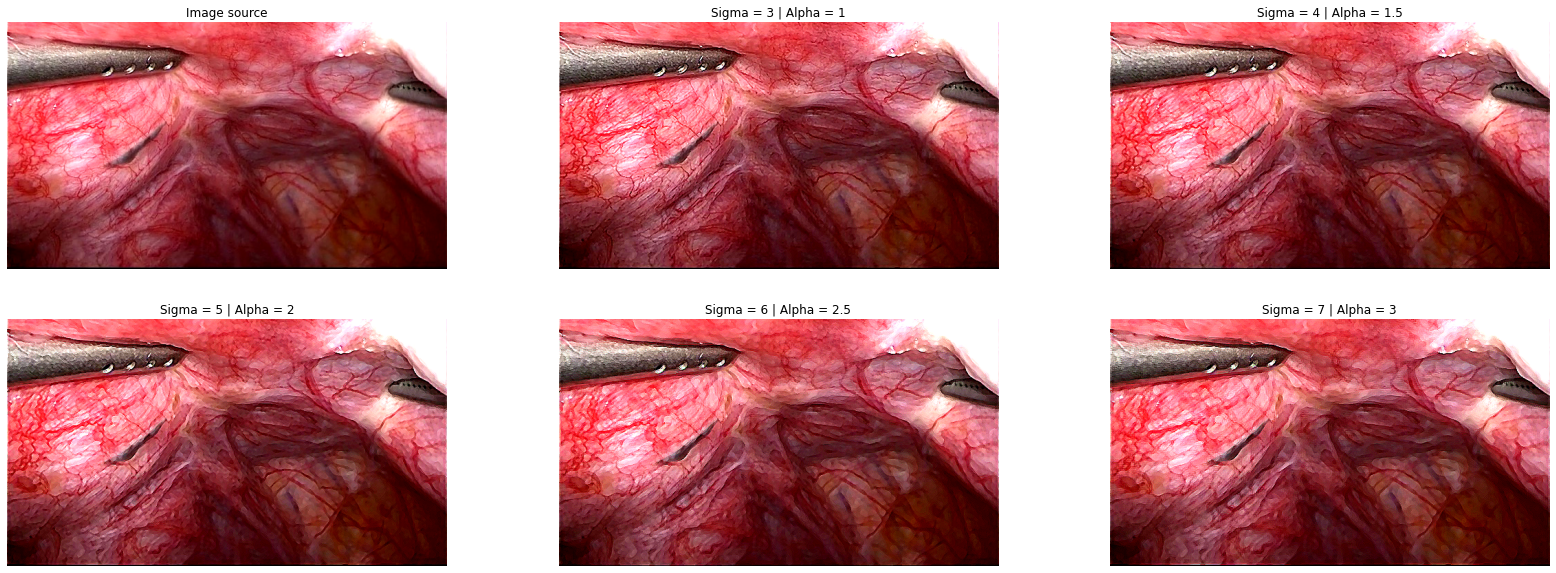

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(28, 10))

axs[0,0].imshow(img_rescale)
axs[0,0].axis('off')
axs[0,0].set_title("Image source")

axs[0,1].imshow(sharp1)
axs[0,1].axis('off')
axs[0,1].set_title("Sigma = 3 | Alpha = 1")

axs[0,2].imshow(sharp2)
axs[0,2].axis('off')
axs[0,2].set_title("Sigma = 4 | Alpha = 1.5")

axs[1,0].imshow(sharp3)
axs[1,0].axis('off')
axs[1,0].set_title("Sigma = 5 | Alpha = 2")

axs[1,1].imshow(sharp4)
axs[1,1].axis('off')
axs[1,1].set_title("Sigma = 6 | Alpha = 2.5")

axs[1,2].imshow(sharp5)
axs[1,2].axis('off')
axs[1,2].set_title("Sigma = 7 | Alpha = 3")

Après nos différents tests, il semblerait que les meilleurs paramètres pour l'accentuation des contours soient : $σ = 5$ et $α = 2.5$ <br>
Ainsi, nous pouvons définir le traitement des images comme suit :

Text(0.5, 1.0, 'Accentuation - Image finale')

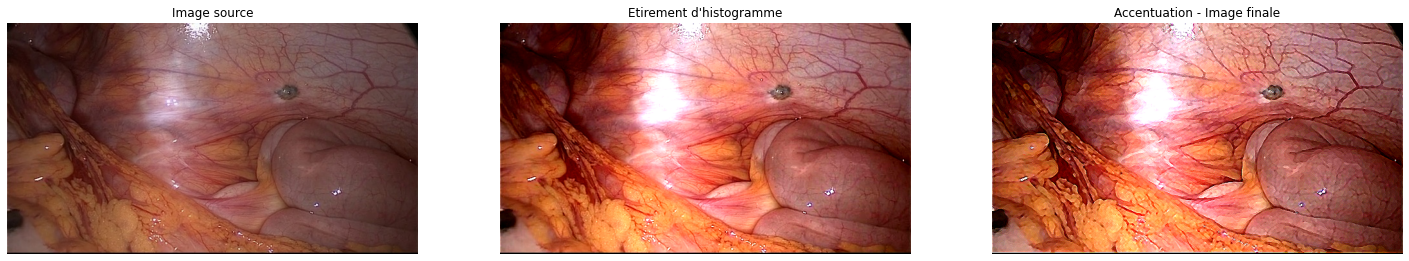

In [7]:
source_img, _ = utils.getImgMsk(df, 5213)
img_stretched = filter.hist_stretching(source_img)
img_sharped = filter.sharpening(img_stretched, 5, 2.5)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(25,10))

ax0.imshow(source_img)
ax0.axis('off')
ax0.set_title("Image source")

ax1.imshow(img_stretched)
ax1.axis('off')
ax1.set_title("Etirement d\'histogramme")

ax2.imshow(img_sharped)
ax2.axis('off')
ax2.set_title("Accentuation - Image finale")

Il ne faut pas oublier qu'il nous reste des images dans lesquelles il faut rajouter une bande sur les bords pour que leurs tailles puissent correspondre avec le format (640, 360).

In [2]:
df = pd.read_csv('run/dataset_final.csv', header=0)
df = df.sort_values(['Taille_image', 'Taille_masque'], ascending=True)
print(df['Taille_image'].value_counts())
display(df.head(10))
source_img, source_msk = utils.getImgMsk(df, 0)

(640, 360)    12224
(480, 360)      220
Name: Taille_image, dtype: int64


Chemin_image Taille_image  \
641   /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1470  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1471  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1472  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1473  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1474  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1475  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1476  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1477  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   
1478  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...   (480, 360)   

                                          Chemin_masque Taille_masque  
641   /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1470  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1471  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1472  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1473  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1474  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1475  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1476  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1477  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)  
1478  /media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...    (480, 360)

Taille de l'image :  (360, 480, 3)
Taille du masque :  (360, 480)


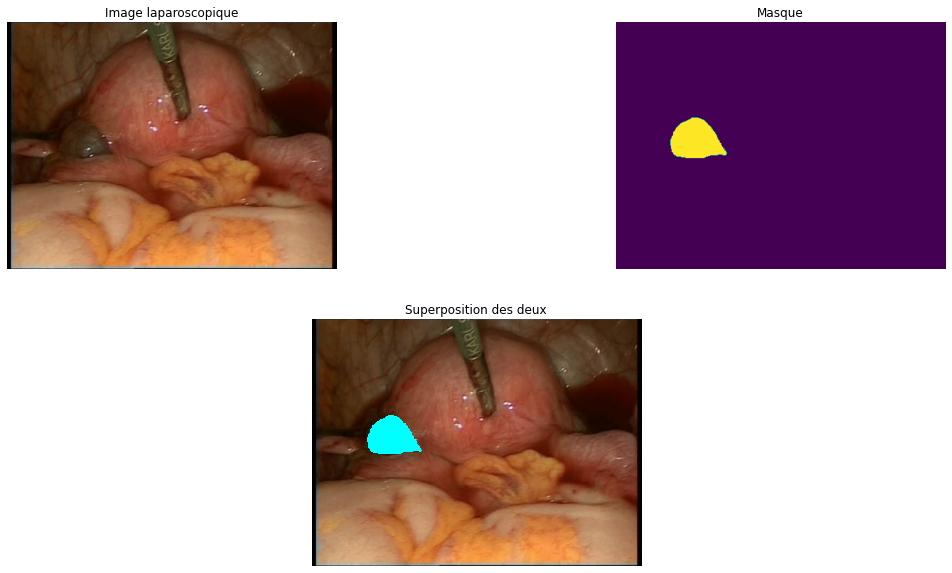

In [3]:
# Avant traitement
print("Taille de l\'image : ", source_img.shape)
print("Taille du masque : ", source_msk.shape)
disp.plot3(source_img, source_msk)

Taille de l'image :  (384, 640, 3)
Taille du masque :  (384, 640)
Nombre de valeurs dans le masque avant l'auto-encodage :  [  0 118]
Nombre de valeurs dans le masque après l'auto-encodage :  [0 1]


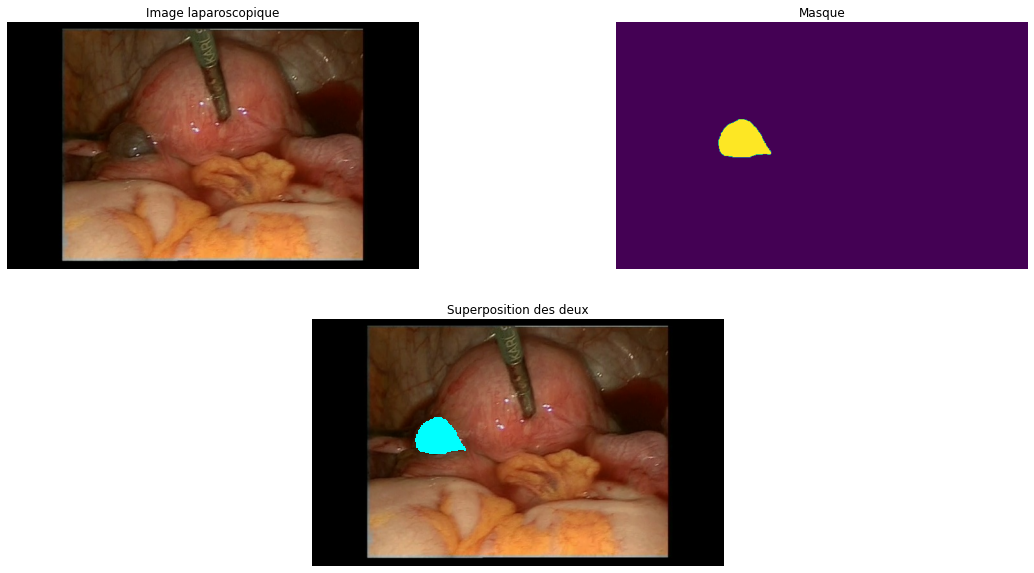

In [10]:
aug_img, aug_msk = utils.resize_img_mask(384, 640, source_img, source_msk)

# Après traitement
print("Taille de l\'image : ", aug_img.shape)
print("Taille du masque : ", aug_msk.shape)
print("Nombre de valeurs dans le masque avant l'auto-encodage : ", np.unique(aug_msk))

aug_msk[aug_msk == 118] = 1
print("Nombre de valeurs dans le masque après l'auto-encodage : ", np.unique(aug_msk))

disp.plot3(aug_img, aug_msk)


Nous disposons à present de tous les outils pour pouvoir créer notre dataset.
Rendez-vous dans le troisième Notebook pour découvrir la suite !